In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
import numpy as np
import pandas as pd
import re
import glob
import os 
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# 'cuda:0'

In [2]:
# build the dataset
class MyDataset(Dataset):
    def __init__(self,root_dir):
        self.root_dir=root_dir
        
        self.filenames=sorted(glob.glob(os.path.abspath("{root}/*.csv".format(root=root_dir))))
        self.waveforms=self.getwaveforms(self.filenames)
        
    def getwaveforms(self,files):
        files_num=len(files)
        waveforms=[]
        print("building the dataset...")
        for i in tqdm(range(files_num)):
            waveforms.append(torch.tensor([pd.read_csv(files[i]).iloc[:,0].values]).to(torch.float32))
#         waveforms=torch.tensor(waveforms).to(torch.float32)
        return waveforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self,idx):
        label=re.findall(r"\\\d+-",self.filenames[idx])#re.findall(r"/\d+-",self.filenames[idx])
        return self.waveforms[idx],int(label[0][1:-1])

In [3]:
dataset=MyDataset("F:/Python/data processing/TDC")
dataset_len=len(dataset)
trainset_len=int(0.95*dataset_len)
trainset,testset=torch.utils.data.random_split(dataset,[trainset_len,dataset_len-trainset_len])
def pad_sequence(batch):
    batch=[item.t() for item in batch]
    batch=torch.nn.utils.rnn.pad_sequence(batch,batch_first=True,padding_value=0.)
    return batch.permute(0,2,1)

def collate_fn(batch):
    tensors,targets=[],[]
    for waveform,label in batch:
        tensors+=[waveform]
        targets+=[torch.tensor(label)]
    tensors=pad_sequence(tensors)
    targets=torch.stack(targets)
    return tensors,targets

batch_size=64
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
testloader=DataLoader(testset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

building the dataset...


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_32896\1325889612.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  waveforms.append(torch.tensor([pd.read_csv(files[i]).iloc[:,0].values]).to(torch.float32))
100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 502.51it/s]


In [4]:
# define the model
class M(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, 8, kernel_size=5, stride=stride)
        self.bn1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(4)
#         self.conv5 = nn.Conv1d(64, 128, kernel_size=3)
#         self.bn5 = nn.BatchNorm1d(128)
#         self.pool5 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(64, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
#         x = self.conv5(x)
#         x = F.relu(self.bn5(x))
#         x = self.pool5(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M(n_input=1, n_output=10)
model=model.to(device)
summary(model,(1,2000))

print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
n = count_parameters(model)
print("Number of parameters: %s" % n)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 1996]              48
       BatchNorm1d-2              [-1, 8, 1996]              16
         MaxPool1d-3               [-1, 8, 499]               0
            Conv1d-4              [-1, 16, 497]             400
       BatchNorm1d-5              [-1, 16, 497]              32
         MaxPool1d-6              [-1, 16, 124]               0
            Conv1d-7              [-1, 32, 122]           1,568
       BatchNorm1d-8              [-1, 32, 122]              64
         MaxPool1d-9               [-1, 32, 30]               0
           Conv1d-10               [-1, 64, 28]           6,208
      BatchNorm1d-11               [-1, 64, 28]             128
        MaxPool1d-12                [-1, 64, 7]               0
           Linear-13                [-1, 1, 10]             650
Total params: 9,114
Trainable params: 9

In [5]:
# define the optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.12, total_steps=1000)

In [6]:
def train(model,epoch,log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data=data.to(device).to(torch.float32)
        target=target.to(device)
        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"\tLoss: {loss.item():.6f}")
            losses.append(loss.item())

In [7]:
def number_of_correct(pred, target):
#     count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
#     find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in trainloader:

        data = data.to(torch.float32).to(device)
        target=target.to(device)
#         apply transform and model on whole batch directly on device
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)   
  

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(trainloader.dataset)} ({100. * correct / len(trainloader.dataset):.0f}%)\n")
    return correct/(len(trainloader.dataset))

In [8]:
log_interval = 20
n_epoch = 200

losses = []
accuracy=[]
lr=[]

for epoch in tqdm(range(1, n_epoch + 1)):
    train(model, epoch, log_interval)
    accuracy+=[test(model, epoch)]
    lr.append(scheduler.get_last_lr()[0])
#     if accuracy[-1]>0.97:
#         break
    scheduler.step()

  0%|▍                                                                                 | 1/200 [00:00<00:19, 10.00it/s]

	Loss: 2.371318

Test Epoch: 1	Accuracy: 19/190 (10%)

	Loss: 3.880647


  1%|▊                                                                                 | 2/200 [00:00<00:19,  9.94it/s]


Test Epoch: 2	Accuracy: 18/190 (9%)

	Loss: 2.559546


  2%|█▋                                                                                | 4/200 [00:00<00:18, 10.40it/s]


Test Epoch: 3	Accuracy: 18/190 (9%)

	Loss: 2.420722

Test Epoch: 4	Accuracy: 18/190 (9%)

	Loss: 2.269184

Test Epoch: 5	Accuracy: 18/190 (9%)



  3%|██▍                                                                               | 6/200 [00:00<00:18, 10.67it/s]

	Loss: 2.337837

Test Epoch: 6	Accuracy: 19/190 (10%)

	Loss: 2.328247

Test Epoch: 7	Accuracy: 16/190 (8%)

	Loss: 2.313214


  4%|███▎                                                                              | 8/200 [00:00<00:17, 10.99it/s]


Test Epoch: 8	Accuracy: 18/190 (9%)

	Loss: 2.281664

Test Epoch: 9	Accuracy: 22/190 (12%)

	Loss: 2.279629

Test Epoch: 10	Accuracy: 27/190 (14%)


  6%|████▊                                                                            | 12/200 [00:01<00:17, 11.02it/s]


	Loss: 2.251906

Test Epoch: 11	Accuracy: 28/190 (15%)

	Loss: 2.258118

Test Epoch: 12	Accuracy: 39/190 (21%)

	Loss: 2.219642


  7%|█████▋                                                                           | 14/200 [00:01<00:16, 11.29it/s]


Test Epoch: 13	Accuracy: 21/190 (11%)

	Loss: 2.216341

Test Epoch: 14	Accuracy: 22/190 (12%)

	Loss: 2.184101

Test Epoch: 15	Accuracy: 30/190 (16%)

	Loss: 2.079342


  9%|███████▎                                                                         | 18/200 [00:01<00:15, 11.53it/s]


Test Epoch: 16	Accuracy: 31/190 (16%)

	Loss: 2.090331

Test Epoch: 17	Accuracy: 33/190 (17%)

	Loss: 2.155551

Test Epoch: 18	Accuracy: 32/190 (17%)

	Loss: 2.067501


 10%|████████                                                                         | 20/200 [00:01<00:15, 11.64it/s]


Test Epoch: 19	Accuracy: 28/190 (15%)

	Loss: 2.033497

Test Epoch: 20	Accuracy: 25/190 (13%)

	Loss: 2.026175

Test Epoch: 21	Accuracy: 34/190 (18%)

	Loss: 1.975467


 12%|█████████▋                                                                       | 24/200 [00:02<00:15, 11.47it/s]


Test Epoch: 22	Accuracy: 46/190 (24%)

	Loss: 1.935547

Test Epoch: 23	Accuracy: 48/190 (25%)

	Loss: 1.907253

Test Epoch: 24	Accuracy: 26/190 (14%)



 13%|██████████▌                                                                      | 26/200 [00:02<00:15, 11.09it/s]

	Loss: 1.936427

Test Epoch: 25	Accuracy: 23/190 (12%)

	Loss: 1.911648

Test Epoch: 26	Accuracy: 31/190 (16%)

	Loss: 1.793892


 14%|███████████▎                                                                     | 28/200 [00:02<00:15, 10.91it/s]


Test Epoch: 27	Accuracy: 27/190 (14%)

	Loss: 1.841547

Test Epoch: 28	Accuracy: 25/190 (13%)

	Loss: 1.778048

Test Epoch: 29	Accuracy: 42/190 (22%)



 15%|████████████▏                                                                    | 30/200 [00:02<00:15, 10.78it/s]

	Loss: 1.847929

Test Epoch: 30	Accuracy: 66/190 (35%)

	Loss: 1.636639

Test Epoch: 31	Accuracy: 55/190 (29%)

	Loss: 1.808416


 16%|████████████▉                                                                    | 32/200 [00:02<00:15, 10.91it/s]


Test Epoch: 32	Accuracy: 69/190 (36%)

	Loss: 1.631963

Test Epoch: 33	Accuracy: 39/190 (21%)

	Loss: 1.687625

Test Epoch: 34	Accuracy: 48/190 (25%)



 18%|██████████████▌                                                                  | 36/200 [00:03<00:14, 11.24it/s]

	Loss: 1.628723

Test Epoch: 35	Accuracy: 92/190 (48%)

	Loss: 1.723738

Test Epoch: 36	Accuracy: 85/190 (45%)

	Loss: 1.630494


 19%|███████████████▍                                                                 | 38/200 [00:03<00:14, 11.18it/s]


Test Epoch: 37	Accuracy: 42/190 (22%)

	Loss: 1.578529

Test Epoch: 38	Accuracy: 40/190 (21%)

	Loss: 1.544990

Test Epoch: 39	Accuracy: 92/190 (48%)



 20%|████████████████▏                                                                | 40/200 [00:03<00:14, 11.25it/s]

	Loss: 1.540067

Test Epoch: 40	Accuracy: 91/190 (48%)

	Loss: 1.465769

Test Epoch: 41	Accuracy: 87/190 (46%)

	Loss: 1.422754


 22%|█████████████████▊                                                               | 44/200 [00:03<00:13, 11.36it/s]


Test Epoch: 42	Accuracy: 75/190 (39%)

	Loss: 1.480949

Test Epoch: 43	Accuracy: 73/190 (38%)

	Loss: 1.386844

Test Epoch: 44	Accuracy: 69/190 (36%)

	Loss: 1.449237


 23%|██████████████████▋                                                              | 46/200 [00:04<00:13, 11.54it/s]


Test Epoch: 45	Accuracy: 88/190 (46%)

	Loss: 1.419252

Test Epoch: 46	Accuracy: 99/190 (52%)

	Loss: 1.372202

Test Epoch: 47	Accuracy: 98/190 (52%)

	Loss: 1.410590


 24%|███████████████████▍                                                             | 48/200 [00:04<00:13, 11.65it/s]


Test Epoch: 48	Accuracy: 95/190 (50%)

	Loss: 1.373642

Test Epoch: 49	Accuracy: 102/190 (54%)

	Loss: 1.335624

Test Epoch: 50	Accuracy: 104/190 (55%)



 26%|█████████████████████                                                            | 52/200 [00:04<00:12, 11.55it/s]

	Loss: 1.377891

Test Epoch: 51	Accuracy: 109/190 (57%)

	Loss: 1.379058

Test Epoch: 52	Accuracy: 113/190 (59%)

	Loss: 1.332425


 27%|█████████████████████▊                                                           | 54/200 [00:04<00:12, 11.66it/s]


Test Epoch: 53	Accuracy: 119/190 (63%)

	Loss: 1.359490

Test Epoch: 54	Accuracy: 119/190 (63%)

	Loss: 1.390997

Test Epoch: 55	Accuracy: 120/190 (63%)

	Loss: 1.366638


 29%|███████████████████████▍                                                         | 58/200 [00:05<00:12, 11.45it/s]


Test Epoch: 56	Accuracy: 117/190 (62%)

	Loss: 1.301567

Test Epoch: 57	Accuracy: 115/190 (61%)

	Loss: 1.414199

Test Epoch: 58	Accuracy: 124/190 (65%)

	Loss: 1.389766


 30%|████████████████████████▎                                                        | 60/200 [00:05<00:12, 11.43it/s]


Test Epoch: 59	Accuracy: 120/190 (63%)

	Loss: 1.295823

Test Epoch: 60	Accuracy: 109/190 (57%)

	Loss: 1.318797

Test Epoch: 61	Accuracy: 101/190 (53%)

	Loss: 1.361380


 32%|█████████████████████████▉                                                       | 64/200 [00:05<00:11, 11.42it/s]


Test Epoch: 62	Accuracy: 108/190 (57%)

	Loss: 1.325736

Test Epoch: 63	Accuracy: 108/190 (57%)

	Loss: 1.226135

Test Epoch: 64	Accuracy: 111/190 (58%)

	Loss: 1.244061


 33%|██████████████████████████▋                                                      | 66/200 [00:05<00:11, 11.60it/s]


Test Epoch: 65	Accuracy: 115/190 (61%)

	Loss: 1.189343

Test Epoch: 66	Accuracy: 119/190 (63%)

	Loss: 1.243155

Test Epoch: 67	Accuracy: 122/190 (64%)

	Loss: 1.304395


 34%|███████████████████████████▌                                                     | 68/200 [00:06<00:11, 11.61it/s]


Test Epoch: 68	Accuracy: 125/190 (66%)

	Loss: 1.242238

Test Epoch: 69	Accuracy: 127/190 (67%)

	Loss: 1.210788

Test Epoch: 70	Accuracy: 121/190 (64%)



 36%|█████████████████████████████▏                                                   | 72/200 [00:06<00:10, 11.72it/s]

	Loss: 1.251338

Test Epoch: 71	Accuracy: 120/190 (63%)

	Loss: 1.310591

Test Epoch: 72	Accuracy: 116/190 (61%)

	Loss: 1.170395


 37%|█████████████████████████████▉                                                   | 74/200 [00:06<00:11, 11.45it/s]


Test Epoch: 73	Accuracy: 116/190 (61%)

	Loss: 1.332762

Test Epoch: 74	Accuracy: 118/190 (62%)

	Loss: 1.232064

Test Epoch: 75	Accuracy: 119/190 (63%)

	Loss: 1.241179


 39%|███████████████████████████████▌                                                 | 78/200 [00:06<00:10, 11.73it/s]


Test Epoch: 76	Accuracy: 119/190 (63%)

	Loss: 1.231964

Test Epoch: 77	Accuracy: 121/190 (64%)

	Loss: 1.191272

Test Epoch: 78	Accuracy: 120/190 (63%)

	Loss: 1.145802


 40%|████████████████████████████████▍                                                | 80/200 [00:07<00:10, 11.74it/s]


Test Epoch: 79	Accuracy: 120/190 (63%)

	Loss: 1.242206

Test Epoch: 80	Accuracy: 121/190 (64%)

	Loss: 1.229122

Test Epoch: 81	Accuracy: 123/190 (65%)

	Loss: 1.159534


 42%|██████████████████████████████████                                               | 84/200 [00:07<00:09, 11.73it/s]


Test Epoch: 82	Accuracy: 120/190 (63%)

	Loss: 1.191761

Test Epoch: 83	Accuracy: 118/190 (62%)

	Loss: 1.277693

Test Epoch: 84	Accuracy: 118/190 (62%)

	Loss: 1.175305


 43%|██████████████████████████████████▊                                              | 86/200 [00:07<00:09, 11.78it/s]


Test Epoch: 85	Accuracy: 119/190 (63%)

	Loss: 1.115702

Test Epoch: 86	Accuracy: 120/190 (63%)

	Loss: 1.192708

Test Epoch: 87	Accuracy: 120/190 (63%)

	Loss: 1.261681


 44%|███████████████████████████████████▋                                             | 88/200 [00:07<00:09, 11.72it/s]


Test Epoch: 88	Accuracy: 121/190 (64%)

	Loss: 1.199765

Test Epoch: 89	Accuracy: 120/190 (63%)

	Loss: 1.224114

Test Epoch: 90	Accuracy: 120/190 (63%)



 46%|█████████████████████████████████████▎                                           | 92/200 [00:08<00:09, 11.51it/s]

	Loss: 1.235331

Test Epoch: 91	Accuracy: 120/190 (63%)

	Loss: 1.427467

Test Epoch: 92	Accuracy: 119/190 (63%)

	Loss: 1.310639


 47%|██████████████████████████████████████                                           | 94/200 [00:08<00:09, 11.51it/s]


Test Epoch: 93	Accuracy: 121/190 (64%)

	Loss: 1.172699

Test Epoch: 94	Accuracy: 121/190 (64%)

	Loss: 1.231559

Test Epoch: 95	Accuracy: 121/190 (64%)



 48%|██████████████████████████████████████▉                                          | 96/200 [00:08<00:09, 11.54it/s]

	Loss: 1.257192

Test Epoch: 96	Accuracy: 121/190 (64%)

	Loss: 1.298966

Test Epoch: 97	Accuracy: 121/190 (64%)

	Loss: 1.242414


 50%|████████████████████████████████████████                                        | 100/200 [00:08<00:08, 11.47it/s]


Test Epoch: 98	Accuracy: 120/190 (63%)

	Loss: 1.177082

Test Epoch: 99	Accuracy: 121/190 (64%)

	Loss: 1.266028

Test Epoch: 100	Accuracy: 121/190 (64%)

	Loss: 1.134298


 51%|████████████████████████████████████████▊                                       | 102/200 [00:08<00:08, 11.57it/s]


Test Epoch: 101	Accuracy: 121/190 (64%)

	Loss: 1.343354

Test Epoch: 102	Accuracy: 121/190 (64%)

	Loss: 1.171812

Test Epoch: 103	Accuracy: 120/190 (63%)

	Loss: 1.113104


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:09<00:08, 11.59it/s]


Test Epoch: 104	Accuracy: 120/190 (63%)

	Loss: 1.193490

Test Epoch: 105	Accuracy: 120/190 (63%)

	Loss: 1.262482

Test Epoch: 106	Accuracy: 120/190 (63%)



 54%|███████████████████████████████████████████▏                                    | 108/200 [00:09<00:07, 11.55it/s]

	Loss: 1.191550

Test Epoch: 107	Accuracy: 120/190 (63%)

	Loss: 1.213196

Test Epoch: 108	Accuracy: 120/190 (63%)

	Loss: 1.123744


 55%|████████████████████████████████████████████                                    | 110/200 [00:09<00:07, 11.30it/s]


Test Epoch: 109	Accuracy: 120/190 (63%)

	Loss: 1.230169

Test Epoch: 110	Accuracy: 120/190 (63%)

	Loss: 1.169578

Test Epoch: 111	Accuracy: 120/190 (63%)

	Loss: 1.161330


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:09<00:07, 11.34it/s]


Test Epoch: 112	Accuracy: 120/190 (63%)

	Loss: 1.135296

Test Epoch: 113	Accuracy: 120/190 (63%)

	Loss: 1.240401

Test Epoch: 114	Accuracy: 121/190 (64%)



 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:10<00:07, 11.28it/s]

	Loss: 1.207769

Test Epoch: 115	Accuracy: 120/190 (63%)

	Loss: 1.262618

Test Epoch: 116	Accuracy: 120/190 (63%)

	Loss: 1.193512


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:10<00:07, 11.42it/s]


Test Epoch: 117	Accuracy: 120/190 (63%)

	Loss: 1.197245

Test Epoch: 118	Accuracy: 121/190 (64%)

	Loss: 1.194474

Test Epoch: 119	Accuracy: 120/190 (63%)

	Loss: 1.141613


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:10<00:06, 11.45it/s]


Test Epoch: 120	Accuracy: 120/190 (63%)

	Loss: 1.126314

Test Epoch: 121	Accuracy: 121/190 (64%)

	Loss: 1.176740

Test Epoch: 122	Accuracy: 121/190 (64%)

	Loss: 1.138101


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:10<00:06, 11.54it/s]


Test Epoch: 123	Accuracy: 121/190 (64%)

	Loss: 1.208392

Test Epoch: 124	Accuracy: 120/190 (63%)

	Loss: 1.238026

Test Epoch: 125	Accuracy: 121/190 (64%)

	Loss: 1.205195


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:11<00:06, 11.50it/s]


Test Epoch: 126	Accuracy: 121/190 (64%)

	Loss: 1.257259

Test Epoch: 127	Accuracy: 120/190 (63%)

	Loss: 1.223090

Test Epoch: 128	Accuracy: 121/190 (64%)

	Loss: 1.222145


 65%|████████████████████████████████████████████████████                            | 130/200 [00:11<00:06, 11.54it/s]


Test Epoch: 129	Accuracy: 121/190 (64%)

	Loss: 1.306684

Test Epoch: 130	Accuracy: 121/190 (64%)

	Loss: 1.240714

Test Epoch: 131	Accuracy: 122/190 (64%)

	Loss: 1.248958


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:11<00:05, 11.47it/s]


Test Epoch: 132	Accuracy: 122/190 (64%)

	Loss: 1.149462

Test Epoch: 133	Accuracy: 120/190 (63%)

	Loss: 1.158357

Test Epoch: 134	Accuracy: 121/190 (64%)



 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:11<00:05, 11.26it/s]

	Loss: 1.199018

Test Epoch: 135	Accuracy: 121/190 (64%)

	Loss: 1.314225

Test Epoch: 136	Accuracy: 120/190 (63%)

	Loss: 1.173969


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:12<00:05, 11.29it/s]


Test Epoch: 137	Accuracy: 121/190 (64%)

	Loss: 1.142952

Test Epoch: 138	Accuracy: 122/190 (64%)

	Loss: 1.252669

Test Epoch: 139	Accuracy: 122/190 (64%)

	Loss: 1.235870


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:12<00:05, 11.47it/s]


Test Epoch: 140	Accuracy: 120/190 (63%)

	Loss: 1.194584

Test Epoch: 141	Accuracy: 120/190 (63%)

	Loss: 1.204885

Test Epoch: 142	Accuracy: 121/190 (64%)

	Loss: 1.145190


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:12<00:04, 11.56it/s]


Test Epoch: 143	Accuracy: 121/190 (64%)

	Loss: 1.121479

Test Epoch: 144	Accuracy: 121/190 (64%)

	Loss: 1.262377

Test Epoch: 145	Accuracy: 121/190 (64%)

	Loss: 1.198005


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:12<00:04, 11.59it/s]


Test Epoch: 146	Accuracy: 121/190 (64%)

	Loss: 1.140104

Test Epoch: 147	Accuracy: 121/190 (64%)

	Loss: 1.283113

Test Epoch: 148	Accuracy: 121/190 (64%)

	Loss: 1.202863


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:13<00:04, 11.65it/s]


Test Epoch: 149	Accuracy: 121/190 (64%)

	Loss: 1.211085

Test Epoch: 150	Accuracy: 122/190 (64%)

	Loss: 1.197524

Test Epoch: 151	Accuracy: 122/190 (64%)

	Loss: 1.228393


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:13<00:03, 12.13it/s]


Test Epoch: 152	Accuracy: 122/190 (64%)

	Loss: 1.121895

Test Epoch: 153	Accuracy: 122/190 (64%)

	Loss: 1.247480

Test Epoch: 154	Accuracy: 121/190 (64%)

	Loss: 1.184189


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:13<00:03, 11.89it/s]


Test Epoch: 155	Accuracy: 122/190 (64%)

	Loss: 1.215523

Test Epoch: 156	Accuracy: 122/190 (64%)

	Loss: 1.261515

Test Epoch: 157	Accuracy: 121/190 (64%)

	Loss: 1.247159


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:13<00:03, 11.54it/s]


Test Epoch: 158	Accuracy: 121/190 (64%)

	Loss: 1.255898

Test Epoch: 159	Accuracy: 121/190 (64%)

	Loss: 1.174126

Test Epoch: 160	Accuracy: 122/190 (64%)



 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:14<00:03, 11.62it/s]

	Loss: 1.238707

Test Epoch: 161	Accuracy: 122/190 (64%)

	Loss: 1.214995

Test Epoch: 162	Accuracy: 121/190 (64%)

	Loss: 1.212930


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:14<00:03, 11.21it/s]


Test Epoch: 163	Accuracy: 122/190 (64%)

	Loss: 1.175917

Test Epoch: 164	Accuracy: 122/190 (64%)

	Loss: 1.225132

Test Epoch: 165	Accuracy: 121/190 (64%)



 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:14<00:03, 11.18it/s]

	Loss: 1.169231

Test Epoch: 166	Accuracy: 121/190 (64%)

	Loss: 1.246496

Test Epoch: 167	Accuracy: 121/190 (64%)

	Loss: 1.257935


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:14<00:02, 11.27it/s]


Test Epoch: 168	Accuracy: 121/190 (64%)

	Loss: 1.225540

Test Epoch: 169	Accuracy: 121/190 (64%)

	Loss: 1.194014

Test Epoch: 170	Accuracy: 121/190 (64%)



 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [00:15<00:02, 11.06it/s]

	Loss: 1.166753

Test Epoch: 171	Accuracy: 122/190 (64%)

	Loss: 1.220999

Test Epoch: 172	Accuracy: 122/190 (64%)

	Loss: 1.236650


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [00:15<00:02, 10.84it/s]


Test Epoch: 173	Accuracy: 121/190 (64%)

	Loss: 1.265958

Test Epoch: 174	Accuracy: 121/190 (64%)

	Loss: 1.261594

Test Epoch: 175	Accuracy: 121/190 (64%)



 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [00:15<00:02, 10.99it/s]

	Loss: 1.298023

Test Epoch: 176	Accuracy: 121/190 (64%)

	Loss: 1.181558

Test Epoch: 177	Accuracy: 121/190 (64%)

	Loss: 1.181816


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [00:15<00:01, 11.14it/s]


Test Epoch: 178	Accuracy: 121/190 (64%)

	Loss: 1.171107

Test Epoch: 179	Accuracy: 121/190 (64%)

	Loss: 1.308175

Test Epoch: 180	Accuracy: 122/190 (64%)



 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [00:15<00:01, 10.83it/s]

	Loss: 1.257219

Test Epoch: 181	Accuracy: 121/190 (64%)

	Loss: 1.194885

Test Epoch: 182	Accuracy: 121/190 (64%)

	Loss: 1.355296


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:16<00:01, 10.65it/s]


Test Epoch: 183	Accuracy: 121/190 (64%)

	Loss: 1.223185

Test Epoch: 184	Accuracy: 121/190 (64%)

	Loss: 1.156017

Test Epoch: 185	Accuracy: 120/190 (63%)



 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [00:16<00:01, 10.43it/s]

	Loss: 1.125204

Test Epoch: 186	Accuracy: 120/190 (63%)

	Loss: 1.192100

Test Epoch: 187	Accuracy: 121/190 (64%)



 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:16<00:01, 10.23it/s]

	Loss: 1.204141

Test Epoch: 188	Accuracy: 121/190 (64%)

	Loss: 1.266665

Test Epoch: 189	Accuracy: 122/190 (64%)

	Loss: 1.319716


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [00:16<00:00, 10.18it/s]


Test Epoch: 190	Accuracy: 121/190 (64%)

	Loss: 1.230296

Test Epoch: 191	Accuracy: 121/190 (64%)

	Loss: 1.297813


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:17<00:00,  9.99it/s]


Test Epoch: 192	Accuracy: 121/190 (64%)

	Loss: 1.192749

Test Epoch: 193	Accuracy: 121/190 (64%)

	Loss: 1.155421

Test Epoch: 194	Accuracy: 121/190 (64%)



 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:17<00:00, 10.04it/s]

	Loss: 1.194937

Test Epoch: 195	Accuracy: 121/190 (64%)

	Loss: 1.228602

Test Epoch: 196	Accuracy: 121/190 (64%)

	Loss: 1.267367


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:17<00:00, 10.32it/s]


Test Epoch: 197	Accuracy: 122/190 (64%)

	Loss: 1.183558

Test Epoch: 198	Accuracy: 122/190 (64%)

	Loss: 1.225733

Test Epoch: 199	Accuracy: 122/190 (64%)

	Loss: 1.222621


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.26it/s]


Test Epoch: 200	Accuracy: 122/190 (64%)



In [9]:
losses=np.array(losses)/max(losses)
# lr=np.array(lr)*10

In [10]:
print(losses)

[0.61106263 1.         0.65956689 0.62379329 0.58474377 0.60243492
 0.59996352 0.59608986 0.58795973 0.58743524 0.58029131 0.58189207
 0.57197723 0.57112674 0.56281887 0.53582364 0.53865525 0.55546169
 0.53277221 0.52400969 0.522123   0.50905612 0.49876928 0.49147814
 0.49899598 0.49261069 0.46226617 0.47454642 0.45818335 0.47619099
 0.42174379 0.46600902 0.4205389  0.43488231 0.41970399 0.44418839
 0.42016029 0.40676955 0.39812693 0.39685836 0.37771243 0.36662803
 0.38162421 0.3573745  0.37345251 0.3657256  0.35360142 0.36349359
 0.35397232 0.3441756  0.35506733 0.35536801 0.34335125 0.35032556
 0.35844454 0.35216749 0.33539945 0.36442339 0.35812752 0.33391923
 0.33983941 0.35081267 0.34162762 0.31596162 0.32058076 0.30648062
 0.32034736 0.33612831 0.32011104 0.31200677 0.32245615 0.33772475
 0.30159791 0.34343819 0.31748936 0.31983819 0.3174635  0.30697772
 0.29526045 0.32010287 0.31673125 0.29879923 0.30710363 0.32924749
 0.30286307 0.2875041  0.3073477  0.32512142 0.30916613 0.3154

In [11]:
print(accuracy)

[0.1, 0.09473684210526316, 0.09473684210526316, 0.09473684210526316, 0.09473684210526316, 0.1, 0.08421052631578947, 0.09473684210526316, 0.11578947368421053, 0.14210526315789473, 0.14736842105263157, 0.20526315789473684, 0.11052631578947368, 0.11578947368421053, 0.15789473684210525, 0.1631578947368421, 0.1736842105263158, 0.16842105263157894, 0.14736842105263157, 0.13157894736842105, 0.17894736842105263, 0.24210526315789474, 0.25263157894736843, 0.1368421052631579, 0.12105263157894737, 0.1631578947368421, 0.14210526315789473, 0.13157894736842105, 0.22105263157894736, 0.3473684210526316, 0.2894736842105263, 0.3631578947368421, 0.20526315789473684, 0.25263157894736843, 0.4842105263157895, 0.4473684210526316, 0.22105263157894736, 0.21052631578947367, 0.4842105263157895, 0.4789473684210526, 0.45789473684210524, 0.39473684210526316, 0.38421052631578945, 0.3631578947368421, 0.4631578947368421, 0.5210526315789473, 0.5157894736842106, 0.5, 0.5368421052631579, 0.5473684210526316, 0.573684210526

In [12]:
print(lr)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.00625, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.00078125, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.000390625, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 0.0001953125, 9.765625e-05, 9.765625e-05, 9.765625e-05, 9.76562

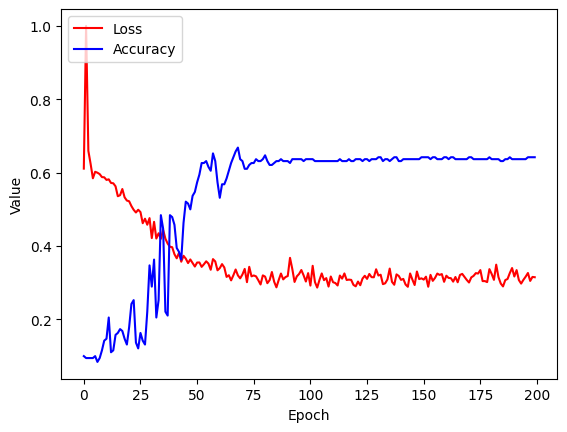

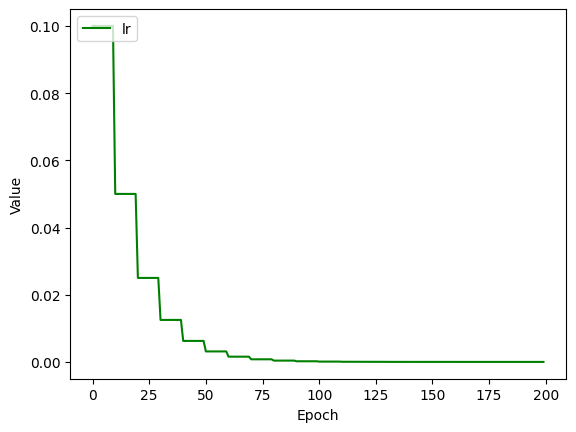

In [13]:
plt.figure()
plt.plot(range(len(losses)),losses,label='Loss', color='red')
plt.plot(range(len(accuracy)),accuracy,label='Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.figure()
plt.plot(range(len(lr)),lr,label='lr', color='green')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()
df=np.array([accuracy,losses,lr])
df=df.T
df=pd.DataFrame(df,columns=["accuracy","loss",'lr'])
df.to_csv("result.csv")
def save_model(net, path):
    torch.save(net, path)
save_model(model, "model.pkl")

In [14]:
def myonetest(model, epoch):
    model.eval().cpu()
    correct = 0
    onepredict=[]
    onetarget=[]
    for data, target in testloader:

        data = data.to(torch.float32)

#         apply transform and model on whole batch directly on device
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)   
#         update progress bar
#         pbar.update(pbar_update)
        pred=list(pred.squeeze().numpy())
        target=list(target.squeeze().numpy())
        onepredict += pred
        onetarget+=target
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.0f}%)\n")
    return (correct/(len(testloader.dataset)),onepredict,onetarget)


Test Epoch: 2	Accuracy: 3/10 (30%)

[9, 3, 1, 4, 4, 1, 0, 4, 0, 7]
10
[3, 9, 6, 2, 5, 2, 0, 4, 0, 6]
[[2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
[['2' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '1' '0' '0' '1' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '1']
 ['0' '0' '0' '0' '1' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '1' '0' '0' '0' '0' '0']
 ['0' '1' '0' '0' '0' '0' '0' '1' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '1' '0' '0' '0' '0' '0' '0']]


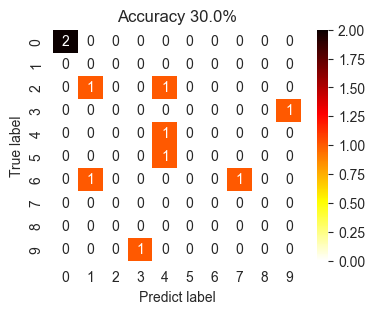

In [15]:
def myConfusionMatrixHeatmap(y_pred,y_true):
    import numpy
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt

    
    sns.set({'figure.figsize': [4,3]})
    f, ax = plt.subplots()
#     y_true = [0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 1]
#     y_pred = [1, 0, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1]
    C2 = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    C2_Acc=C2/20*100
    annot=numpy.zeros(C2.shape).astype(int).astype(str)
    trueSum=0
    for i in range(10):
        trueSum+=C2[i][i];
        for j in range(10):
            if(C2[i][j]!=0):
                annot[i][j]="{}".format(C2[i][j])

    print(C2)
    print(annot)
    sns.heatmap(C2, annot=annot, fmt="", ax=ax, cmap="hot_r")  

    ax.set_title('Accuracy {:.1f}%'.format(trueSum/(dataset_len-trainset_len)*100)) 
    ax.set_xlabel('Predict label')  
    ax.set_ylabel('True label')  
    plt.show()

_,onepredict,onetarget=myonetest(model,2)
print(onepredict)
print(len(onepredict))
print(onetarget)
myConfusionMatrixHeatmap(onepredict,onetarget)